In [1]:
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
import WD_models

In [2]:
catalog = Table.read('data/02_photometry.fits')
print(catalog[['clean', 'insideMask']])

clean = catalog['clean']
catalog['insideMask'][catalog['insideMask'].nonzero()] = 1
catalog['insideMask'] = ~catalog['insideMask']+2
photomask = catalog['insideMask']

clean insideMask
----- ----------
    1          0
    1          0
    1         16
    1          0


In [3]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_5590/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_5590/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_5590/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


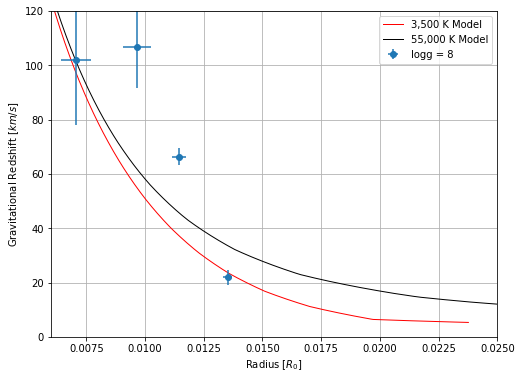

In [4]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'], catalog['g_redshift'], xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], fmt='o', label = 'logg = 8')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()
#plt.savefig('plots/photometry/gredshift_vs_radius.jpg')

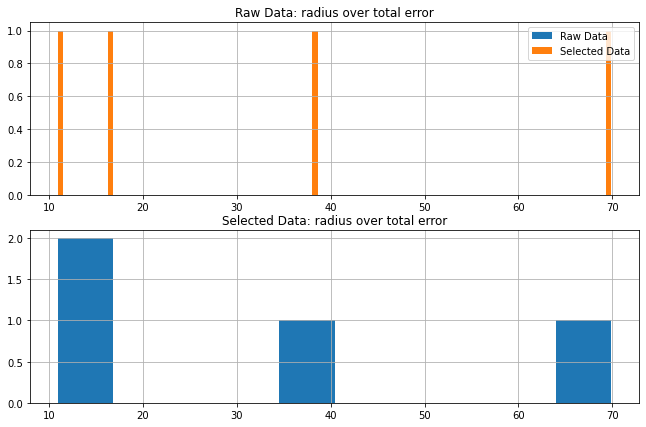

In [5]:
bins = 100

data_raw = catalog['radius_over_error']
roe_mask = np.all([data_raw > 10], axis = 0)

# get histogram xy-data
plt.figure(figsize=(24,7))
plt.subplot(2,2,1)
ydata, x_edges, _ = plt.hist(catalog['radius_over_error'],bins=bins,label='Raw Data')
x_edges = np.array(x_edges)
xdata = (x_edges[1:]+x_edges[:-1])/2

data_selected = data_raw[roe_mask]
    
plt.hist(data_selected,bins=x_edges,label='Selected Data')
plt.title('Raw Data: radius over total error')
plt.grid()
plt.legend()

plt.subplot(2,2,3)
plt.hist(data_selected,label='Selected Data')
plt.title('Selected Data: radius over total error')
plt.grid()
#plt.legend()

plt.show()

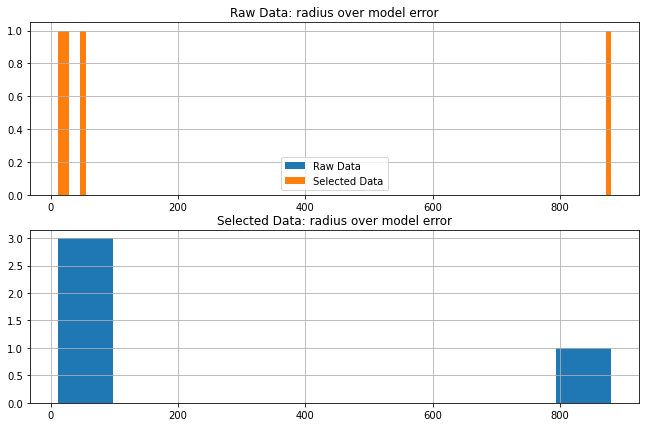

In [6]:
catalog['radius_over_model_error'] = catalog['radius'] / catalog['error_from_model']

data_raw = catalog['radius_over_model_error']
rom_mask = np.all([data_raw > 5], axis = 0)

# get histogram xy-data
plt.figure(figsize=(24,7))
plt.subplot(2,2,1)
ydata, x_edges, _ = plt.hist(catalog['radius_over_model_error'],bins=bins,label='Raw Data')
x_edges = np.array(x_edges)
xdata = (x_edges[1:]+x_edges[:-1])/2

data_selected = data_raw[rom_mask]
    
plt.hist(data_selected,bins=x_edges,label='Selected Data')
plt.title('Raw Data: radius over model error')
plt.grid()
plt.legend()

plt.subplot(2,2,3)
plt.hist(data_selected,label='Selected Data')
plt.title('Selected Data: radius over model error')
plt.grid()
#plt.legend()

plt.show()

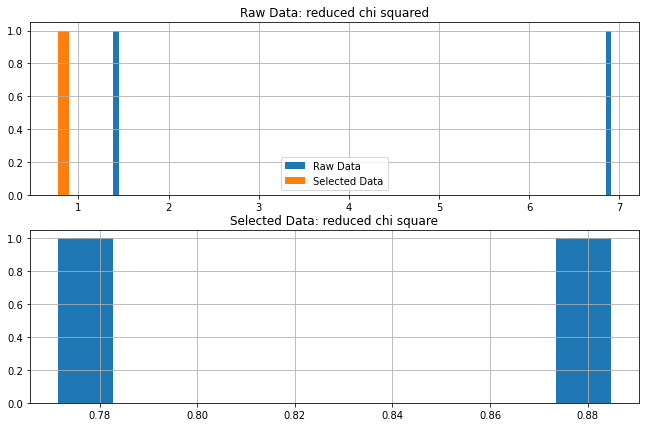

In [7]:
data_raw = catalog['redchi']
redchi_mask = np.all([data_raw < 1], axis = 0)

# get histogram xy-data
plt.figure(figsize=(24,7))
plt.subplot(2,2,1)
ydata, x_edges, _ = plt.hist(catalog['redchi'],bins=bins,label='Raw Data')
x_edges = np.array(x_edges)
xdata = (x_edges[1:]+x_edges[:-1])/2

data_selected = data_raw[redchi_mask]
    
plt.hist(data_selected,bins=x_edges,label='Selected Data')
plt.title('Raw Data: reduced chi squared')
plt.grid()
plt.legend()

plt.subplot(2,2,3)
plt.hist(data_selected,label='Selected Data')
plt.title('Selected Data: reduced chi square')
plt.grid()
#plt.legend()

plt.show()

In [8]:
mask = np.all([clean, photomask, roe_mask, rom_mask, redchi_mask], axis = 0)
#mask = np.all([clean, photomask], axis = 0)
print(mask)

[ True False False  True]


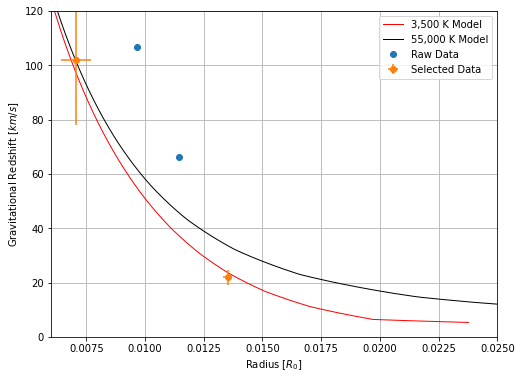

In [9]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

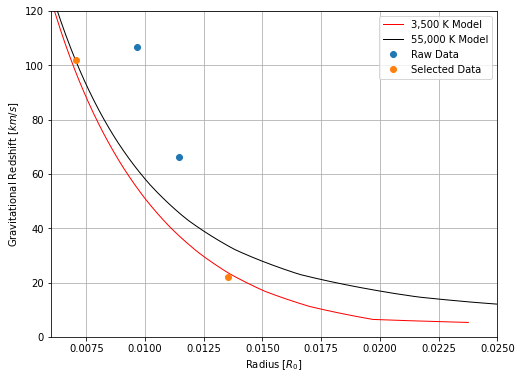

In [10]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

In [11]:
for key in catalog.keys():
    print(key)

solution_id1
solution_id2
source_id1
source_id2
random_index1
random_index2
ref_epoch1
ref_epoch2
ra1
ra2
ra_error1
ra_error2
dec1
dec2
dec_error1
dec_error2
parallax1
parallax2
parallax_error1
parallax_error2
parallax_over_error1
parallax_over_error2
pm1
pm2
pmra1
pmra2
pmra_error1
pmra_error2
pmdec1
pmdec2
pmdec_error1
pmdec_error2
ra_dec_corr1
ra_dec_corr2
ra_parallax_corr1
ra_parallax_corr2
ra_pmra_corr1
ra_pmra_corr2
ra_pmdec_corr1
ra_pmdec_corr2
dec_parallax_corr1
dec_parallax_corr2
dec_pmra_corr1
dec_pmra_corr2
dec_pmdec_corr1
dec_pmdec_corr2
parallax_pmra_corr1
parallax_pmra_corr2
parallax_pmdec_corr1
parallax_pmdec_corr2
pmra_pmdec_corr1
pmra_pmdec_corr2
astrometric_n_obs_al1
astrometric_n_obs_al2
astrometric_n_obs_ac1
astrometric_n_obs_ac2
astrometric_n_good_obs_al1
astrometric_n_good_obs_al2
astrometric_n_bad_obs_al1
astrometric_n_bad_obs_al2
astrometric_gof_al1
astrometric_gof_al2
astrometric_chi2_al1
astrometric_chi2_al2
astrometric_excess_noise1
astrometric_excess_noise2
